In [3]:
import pandas as pd
import numpy as np
from collections import OrderedDict

### Elexon load profiles data
#### https://ukerc.rl.ac.uk/DC/cgi-bin/edc_search.pl?GoButton=Detail&WantComp=42&WantResult=&WantText=EDC0000041

Half-hourly electricity daily load profiles for standard UK profile class definitions (01 Domestic Unrestricted; 02 Domestic Economy 7; 03 Non-domestic Unrestricted; 04 Non-domestic Economy 7; 05 Non-domestic Maximum Demand 0-20% Load Factor; 06 Non-domestic Maximum Demand 20-30% Load Factor; 07 Non-domestic Maximum Demand 30-40% Load Factor; 08 Non-domestic Maximum Demand >40% Load Factor) for weekday (Wd), Saturday (Sat), and Sunday (Sun) at five different times of year (Autumn Aut, Winter Wtr, Spring Spr, High Summer HSr, Summer Smr)

## Functions

In [295]:
def get_metadata():
    url = 'https://data.ukedc.rl.ac.uk/browse/edc/efficiency/residential/LoadProfile/data/AllProfileClasses.xls'
    df = pd.read_excel(url, sheet_name='Introduction', header=5, nrows=8, usecols='A:B', 
                  names=('profile_number', 'profile_name'))
    df = df.set_index('profile_number')
    return df.to_dict()['profile_name']    

In [296]:
def get_raw_data():
    url = 'https://data.ukedc.rl.ac.uk/browse/edc/efficiency/residential/LoadProfile/data/AllProfileClasses.xls'
    dfs = pd.read_excel(url, sheet_name=[
        'Profile Class 1',
        'Profile Class 2',
        'Profile Class 3',
        'Profile Class 4',
        'Profile Class 5',
        'Profile Class 6',
        'ProfileClass 7',
        'Profile Class 8',
    ])
    return dfs

In [303]:
def get_season(raw_profile, season_name):
    df = raw_profile.copy()    
    
    acronyms = {
        'spring' : 'Spr',
        'summer' : 'Smr',
        'high summer' : 'Hsr',
        'autumn' : 'Aut',
        'winter' : 'Wtr' }

    # Spring starts on 29th March, other seasons follow contiguously 
    len_weeks = {
        'spring' : 6,
        'summer' : 10,
        'high summer' : 7,
        'autumn' : 7,
        'winter' : 22 }
    
    acronym = acronyms[season_name.lower()]
    weekdays = np.tile( df[f'{acronym} Wd'].values, 5 )
    sat = df[f'{acronym} Sat'].values
    sun = df[f'{acronym} Sun'].values
    week = np.concatenate( [weekdays, sat, sun] )

    return np.tile( week, len_weeks[season_name.lower()] )

In [347]:
def get_profile(all_profiles, profile_number):
    DAY = 24
    WEEK = 7 * DAY    
    
    # Elexon load profiles are half-hourly, in kW
    profile_name = list( all_profiles.keys() ) [profile_number - 1]  
#     print(f'Getting: {profile_name}')
    raw = dfs[profile_name].copy()
    
    # Resample index to hourly >> values are now in kW AND kWh, due to hourly timebase
    raw.index = pd.timedelta_range(start='00:00:00', periods=48, freq='30min')
    raw = raw.drop(columns=['Time']).resample('1H').mean()
    
    spring, summer, high_summer, autumn, winter = ( get_season(raw, name) 
       for name in ('spring', 'summer', 'high summer', 'autumn', 'winter') )    
    
    # One year = 52 weeks * 7 days * 24 hours (364-day year)
    year_from_spring = np.concatenate([ spring, summer, high_summer, autumn, winter ])
    
    # Spring starts on 29th March -> ~12th week of year    
    index = [ (hour % (WEEK*52)) for hour in range( (12-1)*WEEK, (52+12-1) * WEEK ) ]

    year = pd.DataFrame(year_from_spring, index=index, columns=['kW'])
    year.index.name = 'hour'
    
    return year.sort_index()

In [348]:
def get_annual_kwh(profile):
    annual_kWh = int(round( profile.sum() ))

    return annual_kWh

In [349]:
def get_normalised_profile(profile):
    
    return profile / profile.sum()

In [350]:
def get_monthly_profile(profile):
    monthly_trend = ( profile.groupby(profile.index // (len(profile)//12)).sum() )
    monthly_trend.index = range(1, 13)
    monthly_trend.index.name = 'month'
    monthly_trend = monthly_trend.rename(columns={'kW':'kWh'})
    return monthly_trend

## Build required profiles

domestic,work,public,commercial,delivery

In [351]:
raw_data = get_raw_data()

In [352]:
get_metadata()

{1: 'Domestic Unrestricted (single rate) ',
 2: 'Domestic Economy 7 (two rate) ',
 3: 'Non-Domestic Unrestricted (single rate) ',
 4: 'Non-Domestic Non-Maximum Demand Economy 7 type (two rate) ',
 5: 'Non-Domestic Maximum Demand Customers with Load Factor 0-20%',
 6: 'Non-Domestic Maximum Demand Customers with Load Factor 20-30%',
 7: 'Non-Domestic Maximum Demand Customers with Load Factor 30-40%',
 8: 'Non-Domestic Maximum Demand Customers with Load Factor >40%'}

In [357]:
buildings = {'domestic':1, 'work':3, 'public':3, 'commercial':5, 
             'delivery':3, 'workshop': 6, 'factory':8}

In [358]:
profiles = { building : get_profile( raw_data, profile_number) 
                for  building, profile_number in buildings.items() }

In [361]:
normalised_profiles = { building : get_normalised_profile(profile)
                          for building, profile in profiles.items() }

## Merge and Export Normalised Profiles

In [400]:
normalised_profiles = OrderedDict( normalised_profiles)

In [401]:
norm_profiles_df = pd.DataFrame([ profile['kW'] for profile in normalised_profiles.values() ]).T
norm_profiles_df.columns = [building for building in profiles.keys()]
norm_profiles_df

,domestic,work,public,commercial,delivery,workshop,factory
hour,,,,,,,
0,0.000078,0.000054,0.000054,0.000061,0.000054,0.000063,0.000093
1,0.000061,0.000057,0.000057,0.000077,0.000057,0.000061,0.000090
2,0.000055,0.000056,0.000056,0.000073,0.000056,0.000059,0.000088
3,0.000053,0.000056,0.000056,0.000067,0.000056,0.000058,0.000087
4,0.000053,0.000058,0.000058,0.000069,0.000058,0.000058,0.000087
...,...,...,...,...,...,...,...
8731,0.000222,0.000076,0.000076,0.000049,0.000076,0.000061,0.000115
8732,0.000205,0.000070,0.000070,0.000046,0.000070,0.000063,0.000113
8733,0.000191,0.000066,0.000066,0.000046,0.000066,0.000062,0.000110


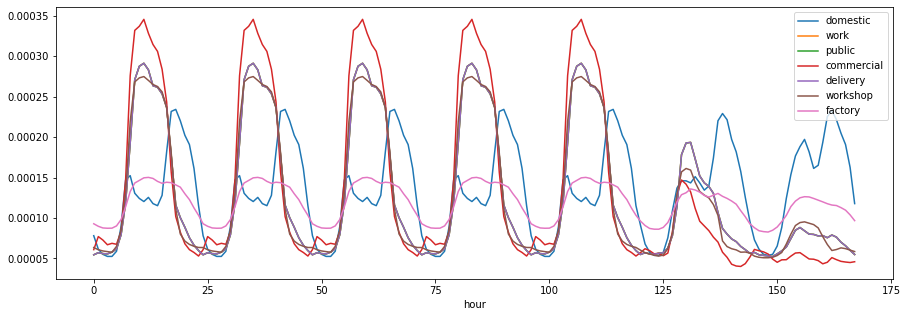

In [402]:
ax = norm_profiles_df[:24*7].plot(figsize=(15,5))

In [403]:
norm_profiles_df.to_csv('cleaned/building_profiles.csv', index=False)

In [405]:
!! head -n 2 cleaned/building_profiles.csv

['domestic,work,public,commercial,delivery,workshop,factory',
 '7.811689617240016e-05,5.4495811792967814e-05,5.4495811792967814e-05,6.0862062993523695e-05,5.4495811792967814e-05,6.347744496754897e-05,9.288456172662599e-05']

## Merge and Export Annual Consumptions

In [406]:
annuals = { building : get_annual_kwh( profile ) 
                for  building, profile in profiles.items() }

In [407]:
annuals

{'domestic': 3904,
 'work': 13487,
 'public': 13487,
 'commercial': 65969,
 'delivery': 13487,
 'workshop': 110275,
 'factory': 190290}

In [421]:
annuals_df = pd.DataFrame.from_dict( annuals, orient='index', columns=('Annual kWh',) )
annuals_df

,Annual kWh
domestic,3904
work,13487
public,13487
commercial,65969
delivery,13487
workshop,110275
factory,190290


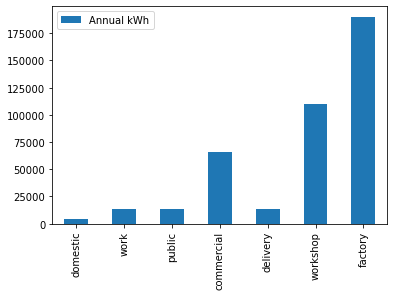

In [422]:
ax = annuals_df.plot.bar()

In [425]:
annuals_df.T.to_csv('cleaned/building_annual_kWh.csv', index=False)

In [428]:
!! cat cleaned/building_annual_kWh.csv

['domestic,work,public,commercial,delivery,workshop,factory',
 '3904,13487,13487,65969,13487,110275,190290']

## Tests

In [322]:
raw_data = get_raw_data()

In [323]:
metadata = get_metadata()
metadata

{1: 'Domestic Unrestricted (single rate) ',
 2: 'Domestic Economy 7 (two rate) ',
 3: 'Non-Domestic Unrestricted (single rate) ',
 4: 'Non-Domestic Non-Maximum Demand Economy 7 type (two rate) ',
 5: 'Non-Domestic Maximum Demand Customers with Load Factor 0-20%',
 6: 'Non-Domestic Maximum Demand Customers with Load Factor 20-30%',
 7: 'Non-Domestic Maximum Demand Customers with Load Factor 30-40%',
 8: 'Non-Domestic Maximum Demand Customers with Load Factor >40%'}

In [324]:
profile = get_profile(raw_data, 1)

Getting: Profile Class 1


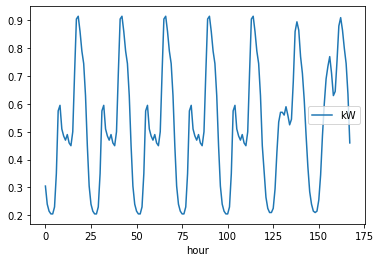

In [325]:
profile[:24*7].plot()

In [326]:
get_annual_kwh(profile)

3904

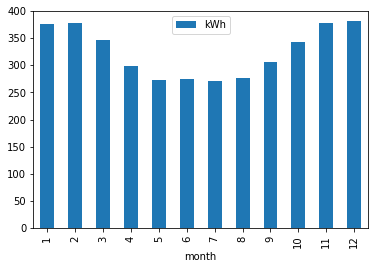

In [327]:
get_monthly_profile(profile).plot.bar()

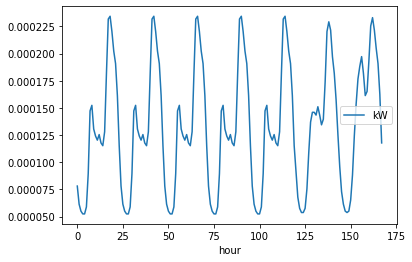

In [328]:
get_normalised_profile(profile)[:24*7].plot()

 Annual Consumption: 5000 kWh


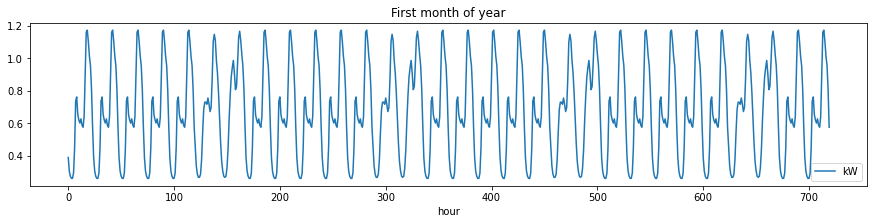

In [329]:
# Example of how to scale to a known annual electricity consumption in kWh
annual_kWh = 5000
scaled = get_normalised_profile(profile) * annual_kWh
print(f' Annual Consumption: {get_annual_kwh(scaled)} kWh')
ax = scaled[:24*30].plot(
    title=f'First month of year',
    figsize=(15,3))

In [1]:
! ls cleaned

building_annual_kWh.csv
building_profiles.csv
charging_behaviour_study_profiles.csv
charging_behaviour_study_trends.csv
impact_of_electric_vehicles_profiles.csv
low_voltage_network_solutions_connection_energies.csv
low_voltage_network_solutions_connection_times.csv
low_voltage_network_solutions_profiles.csv
merge.ipynb
my_electric_avenue_profiles.csv
profiles_for_production_use.csv


In [20]:
df = pd.read_csv('cleaned/building_profiles.csv', header=0)
df.head()

,domestic,work,public,commercial,delivery,workshop,factory
0,0.000078,0.000054,0.000054,0.000061,0.000054,0.000063,0.000093
1,0.000061,0.000057,0.000057,0.000077,0.000057,0.000061,0.000090
2,0.000055,0.000056,0.000056,0.000073,0.000056,0.000059,0.000088
3,0.000053,0.000056,0.000056,0.000067,0.000056,0.000058,0.000087
4,0.000053,0.000058,0.000058,0.000069,0.000058,0.000058,0.000087


In [21]:
df.columns

Index(['domestic', 'work', 'public', 'commercial', 'delivery', 'workshop',
       'factory'],
      dtype='object')

In [22]:
'domestic' in df.columns

True

In [23]:
'shed' in df.columns

False

In [24]:
df['public']

0       0.000054
1       0.000057
2       0.000056
3       0.000056
4       0.000058
          ...   
8731    0.000076
8732    0.000070
8733    0.000066
8734    0.000060
8735    0.000055
Name: public, Length: 8736, dtype: float64

In [29]:
assert True, \
    'could not find'

In [30]:
profile = df['work']

In [32]:
type(profile)

pandas.core.series.Series

In [35]:
pd.read_csv('cleaned/building_profiles.csv', header=0, usecols=['work'])

,work
0,0.000054
1,0.000057
2,0.000056
3,0.000056
4,0.000058
...,...
8731,0.000076
8732,0.000070
8733,0.000066
8734,0.000060
